# 모듈 불러오기

In [1]:
import glob
import os
import re
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

# 데이터 불러오기

In [2]:
txt_file_path = os.getenv('HOME') +'/aiffel/lyricist/data/lyrics/*'

txt_list = glob.glob(txt_file_path)

Raw_corpus = []

#여러 개의 텍스트 파일을 Raw_corpus 리스트에 추가
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        Raw = f.read().splitlines()
        Raw_corpus.extend(Raw)
        
print("데이터 크기:", len(Raw_corpus))
print("Examples:\n", Raw_corpus[1])

데이터 크기: 187088
Examples:
 That David played, and it pleased the Lord


**Raw_corpus에 담긴 문장들 살펴보기**

In [3]:
for idx, r in enumerate(Raw_corpus[:20]):
    print(idx, r)

0 Now I've heard there was a secret chord
1 That David played, and it pleased the Lord
2 But you don't really care for music, do you?
3 It goes like this
4 The fourth, the fifth
5 The minor fall, the major lift
6 The baffled king composing Hallelujah Hallelujah
7 Hallelujah
8 Hallelujah
9 Hallelujah Your faith was strong but you needed proof
10 You saw her bathing on the roof
11 Her beauty and the moonlight overthrew her
12 She tied you
13 To a kitchen chair
14 She broke your throne, and she cut your hair
15 And from your lips she drew the Hallelujah Hallelujah
16 Hallelujah
17 Hallelujah
18 Hallelujah You say I took the name in vain
19 I don't even know the name


# 데이터 전처리

## 토큰화

### 정규표현식

입력된 문장을

    1. 소문자로 바꾸고, 양쪽 공백을 지움
    2. 특수문자 양쪽에 공백을 넣고
    3. 여러 개의 공백은 하나의 공백으로 바꿈
    4. a-zA-Z?.!,¿ 가 아닌 모든 문자를 하나의 공백으로 바꿈
    5. 다시 양쪽의 공백을 지움
    6. 문장의 시작에는 <start>, 끝에는 <end>를 추가

In [4]:
#정제 함수
def preprocess_st(st):
    #1
    st = st.lower().strip()
    #2
    st = re.sub(r"([?.!,¿])", r" \1 ", st)
    #3
    st = re.sub(r'[" "]+', " ", st)
    #4
    st = re.sub(r"[^a-zA-Z?.!,¿]+", " ", st)
    #5
    st = st.strip()
    #6
    st = '<start> ' + st + ' <end>'
    return st

print(preprocess_st("I @m      the Iron  MAN^^"))

<start> i m the iron man <end>


- strip() : 맨 앞과 맨 뒤의 공백을 제거하는 함수

## 정제데이터 구축

정제 함수를 통해 만든 데이터셋에서 토큰화를 진행

끝 단어 < end >를 없애면 소스 문장

첫 단어 < start >를 없애면 타겟 문장

In [5]:
corpus = []

for st in Raw_corpus:
    #문장의 길이가 0인 문장은 무시
    if len(st) == 0: continue
    if st[-1] == ":" : continue
       
    preprocessed_st = preprocess_st(st)
    corpus.append(preprocessed_st)
    
corpus[:5]
# 첫 단어가 <start>, 끝 단어가 <end> 형식으로 맞춰짐

['<start> now i ve heard there was a secret chord <end>',
 '<start> that david played , and it pleased the lord <end>',
 '<start> but you don t really care for music , do you ? <end>',
 '<start> it goes like this <end>',
 '<start> the fourth , the fifth <end>']

In [6]:
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        # 12,000개의 단어를 기억할 수 있는 tokenizer
        # 위에서 이미 정제를 했기 때문에 filter는 불필요
        # 12,000개의 단어에 포함되지 못한 단어는 '<Unknown>'으로 설정
        num_words = 12000,
        filters = ' ',
        oov_token = '<Unknown>')
    
    # corpus를 이용해 tokenizer 내부의 단어장 형성
    tokenizer.fit_on_texts(corpus)
    
    # tokenizer를 이용해 corpus를 tensor로 변환
    tensor = tokenizer.texts_to_sequences(corpus)
    
    # 토큰화 했을 때 토큰의 개수가 15개를 넘어가는 문장을 학습 데이터에서 제외
    tensor_short = []
    for i in range(len(tensor)-1):
        if len(tensor[i]) <= 15: 
            tensor_short.append(tensor[i])
            
    # 입력 데이터의 시퀀스 길이를 일정하게 맞춰줌
    # 시퀀스가 짧을 경우, 문장 뒤에 패딩을 붙여 길이를 맞춰줌
    tensor_short = tf.keras.preprocessing.sequence.pad_sequences(tensor_short, padding='post')

    print(tensor_short, tokenizer)
    return tensor_short, tokenizer
    

In [7]:
tensor_short, tokenizer = tokenize(corpus)

[[   2   50    5 ...    0    0    0]
 [   2   17 2639 ...    0    0    0]
 [   2   36    7 ...   43    3    0]
 ...
 [   2  703   29 ...    0    0    0]
 [   2    5  107 ...    0    0    0]
 [   2  261  200 ...   12    3    0]] <keras_preprocessing.text.Tokenizer object at 0x7f1acd2c5610>


In [8]:
print(tensor_short[:3, :])
#tensor[문장, 토큰]
#모두 정수로 이루어짐
#tokenizer에 구축된 단어 사전의 인덱스

[[   2   50    5   91  297   65   57    9  969 6042    3    0    0    0
     0]
 [   2   17 2639  873    4    8   11 6043    6  329    3    0    0    0
     0]
 [   2   36    7   37   15  164  282   28  299    4   47    7   43    3
     0]]


In [9]:
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 10: break

1 : <Unknown>
2 : <start>
3 : <end>
4 : ,
5 : i
6 : the
7 : you
8 : and
9 : a
10 : to


## 평가 데이터셋 분리

In [10]:
#tensor에서 마지막 토큰을 잘라내 소스 문장을 생성
source = tensor_short[:, :-1]

#tensor에서 <start>를 잘라내서 타겟 문장을 생성
target = tensor_short[:, 1:]

print(source[0])
print(target[0])

# 0-> pad

[   2   50    5   91  297   65   57    9  969 6042    3    0    0    0]
[  50    5   91  297   65   57    9  969 6042    3    0    0    0    0]


In [11]:
enc_train, enc_val, dec_train, dec_val = train_test_split(source, target, test_size = 0.2, 
                                                          random_state = 1004)

In [12]:
print("Source Train:", enc_train.shape)
print("Target Train:", dec_train.shape)

Source Train: (124809, 14)
Target Train: (124809, 14)


# 모델 생성

In [13]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)  #embedding layer
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences = True)  #LSTM layer
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences = True)  #LSTM layer
        self.linear = tf.keras.layers.Dense(vocab_size)   #Denselayer
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
    
embedding_size = 1024
hidden_size = 2048
model = TextGenerator(tokenizer.num_words + 1, embedding_size, hidden_size)

# 모델 학습

In [14]:
#tf.random.set_seed(210)   #같은 값을 도출하기 위해 seed 고정

optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits = True,
    reduction = 'none')

model.compile(loss=loss, optimizer=optimizer)
history = model.fit(enc_train, dec_train, epochs=8, validation_data=(enc_val, dec_val))
print(history.history)

Epoch 1/8
3901/3901 [==============================] - 498s 118ms/step - loss: 2.8789 - val_loss: 2.6086
Epoch 2/8
3901/3901 [==============================] - 475s 122ms/step - loss: 2.3155 - val_loss: 2.3629
Epoch 3/8
3901/3901 [==============================] - 475s 122ms/step - loss: 1.8744 - val_loss: 2.2303
Epoch 4/8
3901/3901 [==============================] - 475s 122ms/step - loss: 1.5431 - val_loss: 2.1962
Epoch 5/8
3901/3901 [==============================] - 475s 122ms/step - loss: 1.3228 - val_loss: 2.2108
Epoch 6/8
3901/3901 [==============================] - 475s 122ms/step - loss: 1.1920 - val_loss: 2.2546
Epoch 7/8
3901/3901 [==============================] - 475s 122ms/step - loss: 1.1198 - val_loss: 2.2991
Epoch 8/8
3901/3901 [==============================] - 476s 122ms/step - loss: 1.0807 - val_loss: 2.3421
{'loss': [2.8788976669311523, 2.3154611587524414, 1.8744287490844727, 1.5430525541305542, 1.322795033454895, 1.1919896602630615, 1.1197575330734253, 1.080724358

In [15]:
min(history.history['val_loss'])

2.1962475776672363

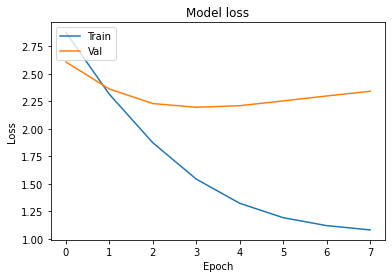

In [19]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

Epoch 2 정도부터 val loss의 감소가 거의 일어나지 않으며 3정도부터는 val loss가 다시 증가하는 것을 알 수 있다.

# 모델 평가

In [17]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len = 20):
    #테스트를 위해서 입력받은 init_sentence도 텐서로 변환
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]
    
    #단어 하나씩 예측해 문장을 만듦
    #    1. 입력받은 문장의 텐서를 입력
    #    2. 예측된 값 중 가장 높은 확률인 word index를 뽑아냄
    #    3. 2에서 에측된 word index 를 문장 뒤에 붙임
    #    4. 모델이 <end>를 예측했거나, max_len에 도달했다면 문장 생성을 마침
    while True:
        #1
        predict = model(test_tensor)
        #2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis= -1), axis=-1)[:,-1]
        #3
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        #4
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break
            
    generated = ""
    #tokenizer를 이용해 word index를 단어로 하나씩 변환
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "
        
    return generated

In [18]:
generate_text(model, tokenizer, init_sentence="<start> i love", max_len=20)

'<start> i love the way you shake your thing <end> '

# 회고

- 너무 지저분하고 더러운 문장이 도출되었다........ 도대체 원본 데이터가 어떻게 되어있길래 이런 문장이 나온 걸까 싶다. 말이 안되진 않지만 몹시 당황스럽다.. 힙합 노래가 많았나 싶다.


- Epoch가 돌 때마다 train loss와 val loss를 출력해주지만 확실히 그래프로 시각화한 것이 결과 추이를 볼 때 편하다.


- 데이터 사이즈를 특정 값에 맞춰야 한다고 써있어서 한 시간 반을 소요했다. 추후에 그 특정 값 이하면 상관없다고 말씀하셔서 허탈했다.


- 보통 embedding size와 hidden size는 2의 제곱수로 설정한다고 알고 있는데 val_loss 값을 떨어트리기 위해 2의 제곱수가 아닌 수들도 시도를 했다. 하지만 결국 2의 제곱수에서 2.2 이하의 val_loss를 도출할 수 있었다. 사람들이 주로 하는 데는 다 이유가 있다.


- hidden layer와 embedding layer를 늘릴수록 낮은 epoch에서 오버피팅이 발견됐다. 하지만 그만큼 낮은 epoch에서 좋은 성능이 나와 높은 layer를 유지했고, epoch 수를 줄였다.


- 텍스트 데이터를 다루는 머신러닝/딥러닝 프로젝트를 조금 더 접해보고 싶다. 물론 이번 프로젝트도 쉽지 않았지만, 더 많은 내용들이 있을 것 같다.


- 정규표현식을 마주할 때마다 매번 새롭다. NLP를 계속 접하면 보다 익숙해지겠거니 싶다. 